In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_rows', None)  # Ото----бражение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [4]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')

volunteers = volunteers[volunteers.athlete_age < 80]
starts = starts[starts.athlete_age < 80]
print(len(starts[starts.finish_time >= 3600]))
starts = starts[starts.finish_time < 3600]
starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)

starts = starts[starts['athlete_age'] > 14]
#индекс дискомфорта
starts['discomfort_index'] = starts['temp'] - (0.55 - 0.0055 * starts['humidity']) * (starts['temp'] - 14.5)

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  
print(starts.isnull().sum())


275
record_id                                 0
athlete_id                                0
event_name                                0
event_date                                0
city                                      0
region                                    0
finish_time                               0
athlete_gender                            0
athlete_age                               0
is_newbie                                 0
temp                                      0
feels_like                                0
pressure                                  0
humidity                                  0
dew_point                                 0
clouds                                    0
wind_speed                                0
wind_deg                                  0
weather.main                              0
weather.description                       0
rain.1h                              151886
snow.1h                              158560
track_description_surface   

Я посмотрел, это происходит в набережных челнах и в каком-то городе московской области, что там на пробежках нет НИ одного волонтера. Это странно, кто же тогда считывал штрихкоды и тп? может быть потом я выкину эти пробежки, но пока просто заполню нулями что там 0 волонтеров (тк так оно и есть, nan появились из-за слияния что по event_name и event_date нет даже 1 волонтера хотя бы 1 роли)

In [5]:
# columns_to_fill = starts.columns.difference(['snow.1h', 'rain.1h'])  
# starts[columns_to_fill] = starts[columns_to_fill].fillna(0)  
# Удаляем строки, где есть NaN, кроме snow.1h и rain.1h  
print(len(starts))
starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])  
print(len(starts))


167411
166595


In [25]:
unique_dates = (
    pd.concat([
        starts[['athlete_id', 'event_date']],
        volunteers[['athlete_id', 'event_date']]
    ])
    .drop_duplicates()
)
date_counts = unique_dates.groupby('athlete_id').size().reset_index(name='unique_event_count')
date_counts['is_repeated'] = (date_counts['unique_event_count'] > 1).astype(int)
starts = starts.merge(date_counts[['athlete_id', 'is_repeated']], on='athlete_id', how='left')
starts['is_repeated'] = starts['is_repeated'].fillna(0).astype(int)


120042

Я решил выкинуть те самые 5 регионов, в которые 5 верст зашли во 2 половине 2023 года

In [27]:
starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  

In [28]:
#starts = starts[starts.event_date >= '2023-01-01'] 
starts = starts[starts.event_date <= '2023-10-15']
# чтобы щас хотя бы как то резульаты были правдивые, я выкину крайние месяцы года, тк там люди могут перестать приходить из за погоды
newbie = starts[starts['is_newbie'] == 1]
print('кол-во уникальных бегунов, которые зарегались до 2023:', len(starts[starts['is_newbie'] == 0].drop_duplicates('athlete_id'))) 
print('кол-во новичков, которые пришли во 2 раз:',len(newbie[newbie.is_repeated == 1].drop_duplicates('athlete_id')))
print('кол-во новичков, которые не пришли после 1 раза:',len(newbie[newbie.is_repeated == 0].drop_duplicates('athlete_id')))

кол-во уникальных бегунов, которые зарегались до 2023: 8428
кол-во новичков, которые пришли во 2 раз: 8235
кол-во новичков, которые не пришли после 1 раза: 8134


In [29]:
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = first_runs[first_runs.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]

print(len(come), len(didnt_come))
first_runs.head(2)

8235 8134


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated_x,is_repeated_y,is_repeated
88061,4805,790126881,Северное Тушино,2023-01-01,Москва,Москва,1702,женский,25,1,0.66,-4.61,1006,100,0.66,100,6.00,200,Clouds,overcast clouds,NaN,NaN,"плитка, асфальт, грунт",0,0.66000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0,0,0
85755,4839,790125938,Вернадского,2023-01-01,Москва,Москва,1945,женский,54,1,1.16,-3.71,1008,98,0.88,100,5.46,215,Clouds,overcast clouds,NaN,NaN,асфальт,0,1.30674,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0


In [30]:
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
cnt_ludei = starts.groupby(['event_name', 'event_date', 'region']).agg(
    cnt_runners = ('athlete_id', 'count'),
)
come_with_didnt_come = come_with_didnt_come.merge(cnt_ludei,on=['event_name', 'event_date', 'region'], how="left")
num_col = come_with_didnt_come.select_dtypes('number')



#print(num_col[(num_col.cnt_runners >= 60)&(num_col.cnt_runners <= 65)].corr(method="spearman")['is_repeated'])
print(num_col.corr(method="spearman")['Маршал'].sort_values(ascending=False))



Маршал                               1.000000
cnt_volunteers                       0.728607
Сканирование штрих-кодов             0.575701
Координация волонтёров               0.563478
cnt_runners                          0.523001
Разное                               0.503323
Фотограф                             0.469473
Замыкающий                           0.468209
Секундомер                           0.466409
Помощь в раздаче карточек позиций    0.445080
Связи с общественностью              0.437952
Хранение и доставка оборудования     0.418842
Организатор                          0.350824
Проверка трассы                      0.331972
Сортировка карточек                  0.329046
Обработка результатов                0.316413
Пейсер                               0.295124
Инструктаж новых участников          0.287231
Проведение разминки                  0.252484
Проверка карточек позиций            0.209291
Завершение мероприятия               0.176512
Раздача карточек позиций          

Откинем не стат значимые корреляции и сделаем логит модель.

In [31]:
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'is_repeated':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])  

        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
num_col_starts = num_col.drop(columns=insignificant_vars)  



Неподходящие целочисленные переменные: ['temp', 'feels_like', 'pressure', 'discomfort_index', 'Координатор парковки', 'Лидер для слабовидящих', 'Организация финиша', 'Раздача карточек позиций', 'Составление отчёта', 'Сурдопереводчик']
10


C:\Users\Semyon\AppData\Local\Temp\ipykernel_11072\2322056393.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])


In [32]:
volunteer_columns = come_with_didnt_come.columns[25:52]  

# Создаем новый DataFrame для хранения результатов  
has_volunt = come_with_didnt_come.copy()  

# Перебираем роли волонтеров  
for column in volunteer_columns:  
    role_name = str(column) # Извлекаем имя роли  
    new_column_name = f'has_{role_name}'  # Создаем новое название колонки  
    has_volunt[new_column_name] = (come_with_didnt_come[column] > 0).astype(int)  # Устанавливаем 1, если есть волонтеры этой роли, иначе 0  

# Удаляем старые колонки с ролями, если требуется  
has_volunt = has_volunt.drop(columns=volunteer_columns)  
has_volunt_numeric = has_volunt.select_dtypes(include=['number'])
display(has_volunt_numeric.corr(method='spearman')['is_repeated'].sort_values(ascending=False))

is_repeated                              1.000000
is_repeated_y                            1.000000
is_repeated_x                            0.980741
rain.1h                                  0.182484
athlete_age                              0.102133
wind_speed                               0.032357
wind_deg                                 0.025391
is_male                                  0.024399
has_Пейсер                               0.019098
has_Координатор парковки                 0.012029
has_Составление отчёта                   0.010802
has_Сурдопереводчик                      0.008615
has_Проведение разминки                  0.007529
has_Лидер для слабовидящих              -0.000866
has_Организация финиша                  -0.004243
temp                                    -0.007549
pressure                                -0.008859
discomfort_index                        -0.009695
feels_like                              -0.011188
has_Раздача карточек позиций            -0.015183


In [33]:
display(has_volunt_numeric.corr(method='spearman')['finish_time'].sort_values(ascending=False))

finish_time                              1.000000
has_Координация волонтёров               0.141124
has_Проверка трассы                      0.101274
cnt_volunteers                           0.091475
athlete_id                               0.089322
has_Помощь в раздаче карточек позиций    0.084300
has_Маршал                               0.075768
has_Разное                               0.068769
athlete_age                              0.062191
cnt_runners                              0.057372
has_Сортировка карточек                  0.054563
has_Проверка карточек позиций            0.042018
has_Завершение мероприятия               0.041956
has_Подготовка мероприятия               0.041352
has_Пейсер                               0.041243
has_Обработка результатов                0.040080
has_Фотограф                             0.036064
has_Связи с общественностью              0.032835
record_id                                0.029678
humidity                                 0.021976


In [34]:
print(num_col.corr(method="spearman")['finish_time'].sort_values(ascending=False))


finish_time                          1.000000
Координация волонтёров               0.147668
Маршал                               0.116609
Организатор                          0.112851
Проверка трассы                      0.104728
cnt_volunteers                       0.091475
athlete_id                           0.089322
Помощь в раздаче карточек позиций    0.083671
Обработка результатов                0.078220
Разное                               0.076031
Сканирование штрих-кодов             0.071617
Связи с общественностью              0.069472
Сортировка карточек                  0.064603
Фотограф                             0.064157
athlete_age                          0.062191
cnt_runners                          0.057372
Замыкающий                           0.054877
Секундомер                           0.052029
Хранение и доставка оборудования     0.047306
Проверка карточек позиций            0.041898
Пейсер                               0.040743
Завершение мероприятия            

<Axes: xlabel='cnt_volunteers', ylabel='Count'>

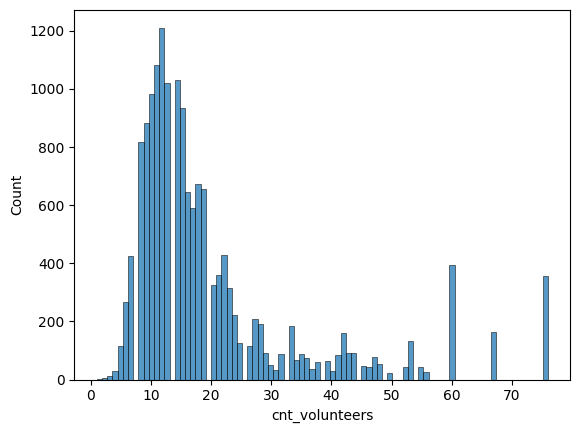

In [35]:
sns.histplot(num_col_starts.cnt_volunteers)

<Axes: xlabel='cnt_runners', ylabel='Count'>

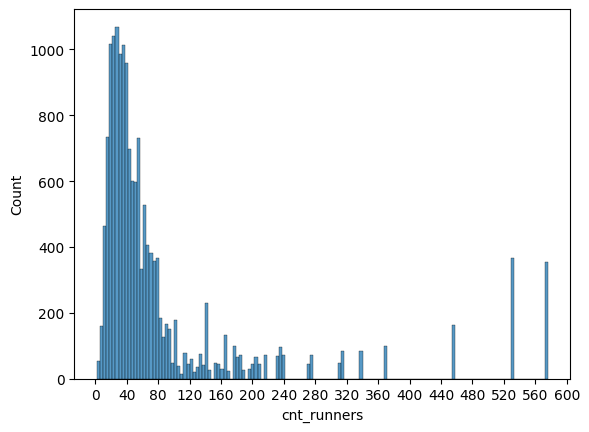

In [36]:
plt.xticks([i for i in range(0, 700, 40)])
sns.histplot(come_with_didnt_come.cnt_runners)

Юзанем катбуст, не откидывая признаков никаких

In [37]:
# %pip install catboost
from catboost import CatBoostClassifier, Pool  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, confusion_matrix 



In [ ]:



# Определяем признаки и целевую переменную  
X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_male', 'cnt_volunteers'], axis=1)  
y = come_with_didnt_come['is_repeated']  
X = X.drop(columns=['Организатор', 'Ведущий велосипед', 'Координатор парковки', 'Лидер для слабовидящих', 'Организатор', 'Пейсер', 'Проверка карточек позиций', 'Сурдопереводчик'],axis=1)


# Определяем категориальные признаки  
categorical_features = ['track_description_surface', 'weather.description', 'weather.main', 'athlete_gender']  

# Создаем и обучаем модель  
model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, cat_features=categorical_features, verbose=0)  
model.fit(X, y)  


# Важность признаков  
feature_importances = model.get_feature_importance()  
for importance, name in sorted(zip(feature_importances, X.columns))[::-1]:  
    print(f'Feature: {name}, Importance: {importance:.2f}')  

In [ ]:
for runners in range(0, 90, 20):
    X = come_with_didnt_come[(come_with_didnt_come.cnt_runners > runners) & (come_with_didnt_come.cnt_runners <= runners + 20)] 
    y = come_with_didnt_come[(come_with_didnt_come.cnt_runners > runners) & (come_with_didnt_come.cnt_runners <= runners + 20)] 
    X = X.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_male', 'cnt_volunteers', 'cnt_runners'], axis=1)  
    y = y['is_repeated']  


    print('Для кол-ва бегунов: ', f'{runners + 1} -- {runners+20}')
    # Определяем категориальные признаки  
    categorical_features = ['track_description_surface', 'weather.description', 'weather.main', 'athlete_gender']  

    # Создаем и обучаем модель  
    model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, cat_features=categorical_features, verbose=0)  
    model.fit(X, y)  


    # Важность признаков  
    feature_importances = model.get_feature_importance()  
    for importance, name in sorted(zip(feature_importances, X.columns))[::-1]:  
        print(f'Feature: {name}, Importance: {importance:.2f}') 
    print('\n'*3)

In [40]:
a = num_col[(num_col.cnt_runners > 50)&(num_col.cnt_runners < 100)]
check_cnt_jogging_with_this_volunteer_and_without = 'Замыкающий'

print(len(a[a[check_cnt_jogging_with_this_volunteer_and_without] == 0]), len(a[a[check_cnt_jogging_with_this_volunteer_and_without] >= 1]))
print()
print(a.corr(method="spearman")['is_repeated'].sort_values(ascending=False))

99 4082

is_repeated                          1.000000
is_repeated_y                        1.000000
is_repeated_x                        0.981514
athlete_age                          0.089886
Пейсер                               0.057583
Раздача карточек позиций             0.044215
is_male                              0.040384
Сортировка карточек                  0.038977
wind_speed                           0.034864
Обработка результатов                0.031193
Хранение и доставка оборудования     0.030337
Связи с общественностью              0.027679
Завершение мероприятия               0.027639
Проведение разминки                  0.026893
rain.1h                              0.026448
Проверка карточек позиций            0.024574
Координатор парковки                 0.023820
Лидер для слабовидящих               0.023803
Сканирование штрих-кодов             0.019162
Сурдопереводчик                      0.018222
pressure                             0.016979
cnt_runners              

In [50]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners > 50) & (come_with_didnt_come.cnt_runners < 100)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners > 50) & (come_with_didnt_come.cnt_runners < 100)]

need_columns = ['Фотограф',   'Замыкающий', 'Подготовка мероприятия', 'Связи с общественностью', 'Маршал',
               'finish_time', 'athlete_age', 'feels_like', 'wind_speed', 'humidity'
              ]

for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.6:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]
for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 50-100 людей')
print('\n')
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.682179
         Iterations 4


Модель для предсказывания is_repeated новичка, в пробежках где было 50-100 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 4181
Model:                          Logit   Df Residuals:                     4170
Method:                           MLE   Df Model:                           10
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.01547
Time:                        17:26:46   Log-Likelihood:                -2852.2
converged:                       True   LL-Null:                       -2897.0
Covariance Type:            nonrobust   LLR p-value:                 6.286e-15
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [23]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 0) & (come_with_didnt_come.cnt_runners <= 50)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 0) & (come_with_didnt_come.cnt_runners <= 50)]

need_columns = ['Фотограф',  'Хранение и доставка оборудования', 'Замыкающий', 
                 'is_male',
               'finish_time', 'athlete_age', 'feels_like', 'wind_speed', 'humidity'
              ]

for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.6:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]
for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 0-50 людей')
print('\n')
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.666009
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 0-50 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 8989
Model:                          Logit   Df Residuals:                     8979
Method:                           MLE   Df Model:                            9
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.02549
Time:                        15:49:11   Log-Likelihood:                -5986.8
converged:                       True   LL-Null:                       -6143.4
Covariance Type:            nonrobust   LLR p-value:                 4.096e-62
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

In [43]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 100) & (come_with_didnt_come.cnt_runners <= 200)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 100) & (come_with_didnt_come.cnt_runners <= 200)]

need_columns = ['Маршал', 'Завершение мероприятия', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций', 'Хранение и доставка оборудования', 
                 'is_male',
               'finish_time', 'athlete_age', 'feels_like', 'wind_speed','humidity'
              ]

for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            coef = X[col1].corr(X[col2],method='spearman')
            if abs(coef) > 0.6:
                print('Возможна мультиколлинеарность: ', coef, col1, col2)

for_model = X[need_columns]
for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 100-200 людей')
print('\n')
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.658017
         Iterations 6


Модель для предсказывания is_repeated новичка, в пробежках где было 100-200 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 1421
Model:                          Logit   Df Residuals:                     1409
Method:                           MLE   Df Model:                           11
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.05053
Time:                        17:24:00   Log-Likelihood:                -935.04
converged:                       True   LL-Null:                       -984.81
Covariance Type:            nonrobust   LLR p-value:                 2.213e-16
                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [57]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 200) & (come_with_didnt_come.cnt_runners <= 500)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 200) & (come_with_didnt_come.cnt_runners <= 500)]

need_columns = [ 'Подготовка мероприятия', 'Организация финиша', 'Хранение и доставка оборудования', 'Связи с общественностью',
                 'is_male',
               'finish_time', 'athlete_age', 'feels_like', 'wind_speed','humidity'
              ]

for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            coef = X[col1].corr(X[col2],method='spearman')
            if abs(coef) > 0.6:
                print('Возможна мультиколлинеарность: ', coef, col1, col2)

for_model = X[need_columns]
for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 200-500 людей')
print('\n')
print(model.summary())


Возможна мультиколлинеарность:  -0.6484438967878625 Подготовка мероприятия Связи с общественностью
Возможна мультиколлинеарность:  -0.6484438967878625 Связи с общественностью Подготовка мероприятия
Optimization terminated successfully.
         Current function value: 0.629429
         Iterations 6


Модель для предсказывания is_repeated новичка, в пробежках где было 200-500 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 1057
Model:                          Logit   Df Residuals:                     1046
Method:                           MLE   Df Model:                           10
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.06042
Time:                        17:32:42   Log-Likelihood:                -665.31
converged:                       True   LL-Null:                       -708.09
Covariance Type:            nonrobust   LLR p-value:         

In [51]:
left_bound = 200
right_bound = 500
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners > left_bound) & (come_with_didnt_come.cnt_runners < right_bound)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners > left_bound) & (come_with_didnt_come.cnt_runners < right_bound)]
X = X.drop(columns=['is_repeated', 'is_repeated_y', 'is_repeated_x', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_newbie', 'is_male', 
    'dew_point','cnt_volunteers','humidity','finish_time', 'athlete_age', 'athlete_gender', 'wind_deg', 'wind_speed', 'feels_like', 'pressure', 'temp', 'clouds', 'discomfort_index', 'snow.1h', 'rain.1h', 'weather.main', 'weather.description', 'track_description_surface'
], axis=1)  
y = y['is_repeated']  


print(f'для новичков которые были на пробежках где людей от {left_bound} до {right_bound}')
# Определяем категориальные признаки  


# Создаем и обучаем модель  
model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1,verbose=0)  
model.fit(X, y)  


# Важность признаков  
feature_importances = model.get_feature_importance()  
for importance, name in sorted(zip(feature_importances, X.columns))[::-1]:  
    print(f'Feature: {name}, Importance: {importance:.2f}') 

# for_model = X[['Маршал', 'Подготовка мероприятия', 'Связи с общественностью', 'Фотограф', 'cnt_volunteers']]
# for_model = sm.add_constant(for_model)

# model = sm.Logit(y, for_model).fit()
# print(model.summary())


для новичков которые были на пробежках где людей от 200 до 500
Feature: cnt_runners, Importance: 17.14
Feature: Связи с общественностью, Importance: 16.30
Feature: Замыкающий, Importance: 6.67
Feature: Организация финиша, Importance: 5.35
Feature: Разное, Importance: 5.33
Feature: Инструктаж новых участников, Importance: 5.07
Feature: Подготовка мероприятия, Importance: 4.79
Feature: Фотограф, Importance: 4.73
Feature: Проведение разминки, Importance: 4.38
Feature: Раздача карточек позиций, Importance: 4.37
Feature: Сканирование штрих-кодов, Importance: 4.20
Feature: Маршал, Importance: 3.51
Feature: Сортировка карточек, Importance: 3.45
Feature: Проверка трассы, Importance: 2.74
Feature: Координация волонтёров, Importance: 2.27
Feature: Обработка результатов, Importance: 2.21
Feature: Помощь в раздаче карточек позиций, Importance: 2.00
Feature: Хранение и доставка оборудования, Importance: 1.98
Feature: Завершение мероприятия, Importance: 1.35
Feature: Пейсер, Importance: 1.12
Feature

In [27]:
small_jogging = num_col[(num_col.cnt_runners > 20) & (num_col.cnt_runners < 80)]
print(len(small_jogging[small_jogging['Инструктаж новых участников'] == 1]), len(small_jogging[small_jogging['Инструктаж новых участников'] == 0]))
x = small_jogging['Проведение разминки']
x = sm.add_constant(x)
y = small_jogging['is_repeated']
model = sm.Logit(y, x).fit()
print(model.summary())

3713 6434
Optimization terminated successfully.
         Current function value: 0.688315
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                10191
Model:                          Logit   Df Residuals:                    10189
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:               9.433e-08
Time:                        15:49:33   Log-Likelihood:                -7014.6
converged:                       True   LL-Null:                       -7014.6
Covariance Type:            nonrobust   LLR p-value:                    0.9710
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1961      0.035      5.682      0.000       0.128     

Теперь я сделаю катбуст но теперь будет не просто кол-во волонтеров, а наличие\отсутствие волонтера

In [ ]:
volunteer_columns = come_with_didnt_come.columns[25:52]  

# Создаем новый DataFrame для хранения результатов  
has_volunt = come_with_didnt_come.copy()  

# Перебираем роли волонтеров  
for column in volunteer_columns:  
    role_name = str(column) # Извлекаем имя роли  
    new_column_name = f'has_{role_name}'  # Создаем новое название колонки  
    has_volunt[new_column_name] = (come_with_didnt_come[column] > 0).astype(int)  # Устанавливаем 1, если есть волонтеры этой роли, иначе 0  

# Удаляем старые колонки с ролями, если требуется  
has_volunt = has_volunt.drop(columns=volunteer_columns)  

for_catboost = has_volunt.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_male', 'cnt_volunteers'], axis=1)
X = for_catboost
y = has_volunt['is_repeated']  



# Определяем категориальные признаки  
categorical_features = for_catboost.select_dtypes(include=['object']).columns.tolist()

# Создаем и обучаем модель  
model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, cat_features=categorical_features, verbose=0)  
model.fit(X, y)  


# Важность признаков  
feature_importances = model.get_feature_importance()  
for importance, name in sorted(zip(feature_importances, X.columns))[::-1]:  
    print(f'Feature: {name}, Importance: {importance:.2f}')  


Feature: cnt_runners, Importance: 17.94
Feature: athlete_age, Importance: 11.57
Feature: finish_time, Importance: 11.03
Feature: wind_speed, Importance: 6.78
Feature: dew_point, Importance: 5.72
Feature: wind_deg, Importance: 5.00
Feature: humidity, Importance: 4.98
Feature: pressure, Importance: 4.88
Feature: discomfort_index, Importance: 4.15
Feature: feels_like, Importance: 3.65
Feature: temp, Importance: 3.39
Feature: track_description_surface, Importance: 2.94
Feature: weather.main, Importance: 2.25
Feature: clouds, Importance: 1.97
Feature: weather.description, Importance: 1.19
Feature: rain.1h, Importance: 1.17
Feature: athlete_gender, Importance: 1.11
Feature: snow.1h, Importance: 0.93
Feature: has_Связи с общественностью, Importance: 0.73
Feature: has_Инструктаж новых участников, Importance: 0.70
Feature: has_Обработка результатов, Importance: 0.70
Feature: has_Ведущий велосипед, Importance: 0.60
Feature: has_Подготовка мероприятия, Importance: 0.54
Feature: has_Хранение и дос

In [ ]:
for_logit = come_with_didnt_come.select_dtypes(include=['number'])

for_logit = for_logit.drop(columns=['record_id', 'athlete_id', 'finish_time', 'athlete_age', 'is_newbie', 'temp', 'feels_like',
'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'rain.1h', 'snow.1h', 'is_male', 'discomfort_index', 'cnt_volunteers'
])

for runners in range(0, 111, 20):
    x = for_logit[(for_logit.cnt_runners > runners) & (for_logit.cnt_runners <= runners + 20)]
    x = x.drop(columns=['is_repeated', 'cnt_runners'], axis=1)
    y = for_logit[(for_logit.cnt_runners > runners) & (for_logit.cnt_runners <= runners + 20)] 
    y = y['is_repeated']
    print(f'модель для {runners+1} -- {runners + 20} бегунов на пробежке (именно бегунов, не новичков)')
    try:
        x = sm.add_constant(x)
        model = sm.Logit(y, x).fit()
        print(model.summary())
    except Exception:
        print('ВОЗНИКЛА ОШИБКА ПРИ ПОСТРОЕНИИ МОДЕЛИ')
    print('\n'*2)
   




модель для 1 -- 20 бегунов на пробежке (именно бегунов, не новичков)
Optimization terminated successfully.
         Current function value: 0.662444
         Iterations 5
ВОЗНИКЛА ОШИБКА ПРИ ПОСТРОЕНИИ МОДЕЛИ



модель для 21 -- 40 бегунов на пробежке (именно бегунов, не новичков)
Optimization terminated successfully.
         Current function value: 0.682319
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5099
Model:                          Logit   Df Residuals:                     5071
Method:                           MLE   Df Model:                           27
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                0.006033
Time:                        11:43:49   Log-Likelihood:                -3479.1
converged:                       True   LL-Null:                       -3500.3
Covariance Type:            nonrobust   LLR p-value:           

In [ ]:
volunteer_columns = num_col_starts.columns[17:37]  

# Создаем новый DataFrame для хранения результатов  
has_volunt = num_col_starts.copy()  

# Перебираем роли волонтеров  
for column in volunteer_columns:  
    role_name = str(column) # Извлекаем имя роли  
    new_column_name = f'has_{role_name}'  # Создаем новое название колонки  
    has_volunt[new_column_name] = (num_col_starts[column] > 0).astype(int)  # Устанавливаем 1, если есть волонтеры этой роли, иначе 0  

# Удаляем старые колонки с ролями, если требуется  
has_volunt = has_volunt.drop(columns=volunteer_columns)  



has_volunt = has_volunt.drop(columns=['record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
        'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure', 'finish_time', 'athlete_age', 'temp', 'is_male', 'discomfort_index', 'cnt_volunteers'
])
for runners in range(0, 130, 20):
    X = has_volunt[(has_volunt.cnt_runners > runners) & (has_volunt.cnt_runners <= runners + 20)]
    y = has_volunt[(has_volunt.cnt_runners > runners) & (has_volunt.cnt_runners <= runners + 20)]
    y = y['is_repeated']
    X = X.drop(columns=['cnt_runners'])
    print(f'модель для {runners+1} --- {runners+20} бегунов(не новичков, а всех бегунов)')
    try:
        X = sm.add_constant(X)
        model = sm.Logit(y, X).fit()
        print(model.summary())
    except Exception:
        print('модель не построилась, ошибка')
    print('\n'*2)

модель для 1 --- 10 бегунов(не новичков, а всех бегунов)
         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 2180
Model:                          Logit   Df Residuals:                     2158
Method:                           MLE   Df Model:                           21
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                   1.000
Time:                        11:47:48   Log-Likelihood:            -8.4839e-06
converged:                      False   LL-Null:                       -1468.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                            

D:\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
D:\Anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
D:\Anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
D:\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\Lib\site-p

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3177
Model:                          Logit   Df Residuals:                     3158
Method:                           MLE   Df Model:                           18
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                   1.000
Time:                        11:47:48   Log-Likelihood:            -0.00022524
converged:                      False   LL-Null:                       -2185.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
is_repeated                              68.7886   6232.083      0.011      0.991   -1.21e

D:\Anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
D:\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
D:\Anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
D:\Anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparatio

In [44]:
for_logit = come_with_didnt_come.select_dtypes(include=['number'])

for_logit = for_logit.drop(columns=['record_id', 'athlete_id', 'finish_time', 'athlete_age', 'is_newbie', 'temp', 'feels_like',
'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'rain.1h', 'snow.1h', 'is_male', 'discomfort_index', 'cnt_volunteers'
])


x = for_logit[(for_logit.cnt_runners > 40) & (for_logit.cnt_runners <= 60)]
print(for_logit[(for_logit.cnt_runners > 40) & (for_logit.cnt_runners <= 60)].corr(method='spearman')['is_repeated'])
x = x.drop(columns=['is_repeated', 'cnt_runners'], axis=1)
y = for_logit[(for_logit.cnt_runners > 40) & (for_logit.cnt_runners <= 60)] 
y = y['is_repeated']
print(f'модель для {40+1} -- {40 + 20} бегунов на пробежке (именно бегунов, не новичков)')
x = sm.add_constant(x)
model = sm.Logit(y, x).fit()
print(model.summary())


Ведущий велосипед                   -0.011448
Завершение мероприятия              -0.008360
Замыкающий                           0.007414
Инструктаж новых участников         -0.023286
Координатор парковки                 0.028444
Координация волонтёров              -0.025354
Лидер для слабовидящих               0.014977
Маршал                              -0.033688
Обработка результатов               -0.020635
Организатор                         -0.011699
Организация финиша                  -0.021251
Пейсер                              -0.011824
Подготовка мероприятия               0.016328
Помощь в раздаче карточек позиций   -0.006284
Проведение разминки                 -0.016493
Проверка карточек позиций            0.014196
Проверка трассы                     -0.021450
Раздача карточек позиций             0.051991
Разное                              -0.000816
Связи с общественностью              0.018943
Секундомер                          -0.002559
Сканирование штрих-кодов          

In [ ]:
from catboost import CatBoostClassifier, Pool  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, confusion_matrix 



# Определяем признаки и целевую переменную  
X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_male', 'cnt_volunteers', 'finish_time'], axis=1)  
y = come_with_didnt_come['finish_time']  

# Разделение данных на обучающую и тестовую выборки  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Определяем категориальные признаки  
categorical_features = ['track_description_surface', 'weather.description', 'weather.main', 'athlete_gender']  

# Создаем и обучаем модель  
model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, cat_features=categorical_features, verbose=0)  
model.fit(X_train, y_train)  

# Делаем предсказания  
y_pred = model.predict(X_test)  

# Оценка качества модели  
accuracy = accuracy_score(y_test, y_pred)  
confusion = confusion_matrix(y_test, y_pred)  

print(f'Accuracy: {accuracy:.2f}')  
print('Confusion Matrix:')  
print(confusion)  

# Важность признаков  
feature_importances = model.get_feature_importance()  
for importance, name in sorted(zip(feature_importances, X.columns))[::-1]:  
    print(f'Feature: {name}, Importance: {importance:.2f}')  

In [10]:
num_col_starts.head(2)

,record_id,athlete_id,finish_time,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,rain.1h,snow.1h,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координация волонтёров,Маршал,Обработка результатов,Организатор,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers,cnt_runners
0,4794,790126885,1437,32,1,-1.91,-1.91,1017,94,-2.65,95,1.31,302,NaN,NaN,1,-1.36847,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,11.0,40
1,4839,790126667,1682,36,1,1.16,-3.71,1008,98,0.88,100,5.46,215,NaN,NaN,1,1.30674,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1,9.0,56


In [16]:
num_col_logit = num_col_starts.drop(columns=['is_repeated', 'record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure','cnt_volunteers', 
'finish_time', 'athlete_age', 'temp', 'is_male', 'discomfort_index'
])

for col in num_col_logit.columns:  
    if col not in ['cnt_runners', 'is_returned']:  
        num_col_logit[f'interaction_{col}'] = num_col_logit['cnt_runners'] * num_col_logit[col]  

X = num_col_logit.drop(['cnt_runners'], axis=1)
# interaction_cols = [col for col in num_col_logit.columns if 'interaction' in col]  
# X = num_col_logit.loc[:, interaction_cols] 

y = num_col_starts['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())



# Если в вашей модели логистической регрессии переменные взаимодействия (например, переменные interaction_..., которые вы создали путем умножения 
# cnt_runners на другие предикторы) имеют p-value < 0.05, это означает, что эффект этого предиктора на целевую переменную is_returned статистически
#  значим и зависит от значения переменной cnt_runners

Optimization terminated successfully.
         Current function value: 0.661093
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16369
Model:                          Logit   Df Residuals:                    16328
Method:                           MLE   Df Model:                           40
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                 0.04466
Time:                        20:25:35   Log-Likelihood:                -10821.
converged:                       True   LL-Null:                       -11327.
Covariance Type:            nonrobust   LLR p-value:                4.095e-186
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                 

In [22]:
num_col_logit = num_col_starts.drop(columns=['is_repeated', 'record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure','cnt_volunteers'
])
X = num_col_logit
y = num_col_starts['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.655533
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16999
Model:                          Logit   Df Residuals:                    16973
Method:                           MLE   Df Model:                           25
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                 0.05312
Time:                        13:51:38   Log-Likelihood:                -11143.
converged:                       True   LL-Null:                       -11769.
Covariance Type:            nonrobust   LLR p-value:                3.239e-248
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 1.1359      0.161      7

In [38]:

num_col_logit = num_col_starts.drop(columns=['is_repeated', 'record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
        'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure'
])
for volonteri in range(10, 45, 10):
    X = num_col_logit[(num_col_logit.cnt_volunteers > volonteri-10) & (num_col_logit.cnt_volunteers <= volonteri)]
    y = num_col_starts[(num_col_logit.cnt_volunteers > volonteri-10) & (num_col_starts.cnt_volunteers <= volonteri)]['is_repeated']  
    X = X.drop(columns=['cnt_volunteers'], axis=1) 
    print(F'ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: {volonteri-10+1} -- {volonteri}')
    try:
        X = sm.add_constant(X)
        model = sm.Logit(y, X).fit()
        print(model.summary())
        print('\n' * 2)
    except Exception:
        print('ошибка')
        #print(X.head(2))
        #print(y.value_counts())
        print('\n' * 2)

X = num_col_logit[(num_col_logit.cnt_volunteers > 50-10) & (num_col_logit.cnt_volunteers <= 100)]
y = num_col_starts[(num_col_logit.cnt_volunteers > 50-10) & (num_col_starts.cnt_volunteers <= 100)]['is_repeated']  
X = X.drop(columns=['cnt_volunteers'], axis=1) 
print(F'ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: {50-10+1} -- maximum')
try:
    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit()
    print(model.summary())
    print('\n' * 2)
except Exception:
    print('ошибка')

        



ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: 1 -- 10
Optimization terminated successfully.
         Current function value: 0.660997
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3650
Model:                          Logit   Df Residuals:                     3624
Method:                           MLE   Df Model:                           25
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                 0.03461
Time:                        14:32:55   Log-Likelihood:                -2412.6
converged:                       True   LL-Null:                       -2499.1
Covariance Type:            nonrobust   LLR p-value:                 4.369e-24
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                   

In [ ]:
#то же самое что и в предыдущей ячейке буду делать, но уже не с количеством определ. волонтера, а наличие/отсутствие


In [37]:
volunteer_columns = num_col_starts.columns[17:37]  

# Создаем новый DataFrame для хранения результатов  
has_volunt = num_col_starts.copy()  

# Перебираем роли волонтеров  
for column in volunteer_columns:  
    role_name = str(column) # Извлекаем имя роли  
    new_column_name = f'has_{role_name}'  # Создаем новое название колонки  
    has_volunt[new_column_name] = (num_col_starts[column] > 0).astype(int)  # Устанавливаем 1, если есть волонтеры этой роли, иначе 0  

# Удаляем старые колонки с ролями, если требуется  
has_volunt = has_volunt.drop(columns=volunteer_columns)  



has_volunt = has_volunt.drop(columns=['record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
        'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure'
])
X = has_volunt
y = has_volunt['is_repeated']  
X = X.drop(columns=['cnt_volunteers', 'is_repeated'], axis=1) 
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.666078
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16999
Model:                          Logit   Df Residuals:                    16973
Method:                           MLE   Df Model:                           25
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                 0.03789
Time:                        14:27:58   Log-Likelihood:                -11323.
converged:                       True   LL-Null:                       -11769.
Covariance Type:            nonrobust   LLR p-value:                4.754e-172
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     1.2394      

In [31]:
volunteer_columns = num_col_starts.columns[17:37]  

# Создаем новый DataFrame для хранения результатов  
has_volunt = num_col_starts.copy()  

# Перебираем роли волонтеров  
for column in volunteer_columns:  
    role_name = str(column) # Извлекаем имя роли  
    new_column_name = f'has_{role_name}'  # Создаем новое название колонки  
    has_volunt[new_column_name] = (num_col_starts[column] > 0).astype(int)  # Устанавливаем 1, если есть волонтеры этой роли, иначе 0  

# Удаляем старые колонки с ролями, если требуется  
has_volunt = has_volunt.drop(columns=volunteer_columns)  
display(has_volunt.head(2))


has_volunt = has_volunt.drop(columns=['record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
        'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure'
])
for volonteri in range(10, 80, 10):
    X = has_volunt[(num_col_logit.cnt_volunteers > volonteri-10) & (num_col_logit.cnt_volunteers <= volonteri)]
    y = has_volunt[(num_col_logit.cnt_volunteers > volonteri-10) & (num_col_starts.cnt_volunteers <= volonteri)]['is_repeated']  
    X = X.drop(columns=['cnt_volunteers', 'is_repeated'], axis=1) 
    print(F'ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: {volonteri-10+1} -- {volonteri}')
    try:
        X = sm.add_constant(X)
        model = sm.Logit(y, X).fit()
        print(model.summary())
        print('\n' * 2)
    except Exception:
        print('ошибка')
        #print(X.head(2))
        #print(y.value_counts())
        print('\n' * 2)

,record_id,athlete_id,finish_time,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,rain.1h,snow.1h,is_male,discomfort_index,is_repeated,cnt_volunteers,has_Ведущий велосипед,has_Завершение мероприятия,has_Замыкающий,has_Инструктаж новых участников,has_Координация волонтёров,has_Маршал,has_Обработка результатов,has_Организатор,has_Подготовка мероприятия,has_Помощь в раздаче карточек позиций,has_Проведение разминки,has_Проверка карточек позиций,has_Проверка трассы,has_Разное,has_Связи с общественностью,has_Секундомер,has_Сканирование штрих-кодов,has_Сортировка карточек,has_Фотограф,has_Хранение и доставка оборудования
106351,4782,790125851,1940,37,1,1.74,-3.68,1025,87,-0.16,75,7.00,260,NaN,NaN,1,2.652340,1,12.0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,1
42589,4816,790090276,1932,56,1,2.71,-1.99,997,95,1.99,100,5.95,263,NaN,NaN,1,3.034225,1,19.0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,1,1,1,0,1,0


ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: 1 -- 10
Optimization terminated successfully.
         Current function value: 0.662186
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3650
Model:                          Logit   Df Residuals:                     3624
Method:                           MLE   Df Model:                           25
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                 0.03287
Time:                        14:23:10   Log-Likelihood:                -2417.0
converged:                       True   LL-Null:                       -2499.1
Covariance Type:            nonrobust   LLR p-value:                 1.870e-22
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const           

In [ ]:


for volonteri in range(10, 80, 10):
    X = num_col_logit[(num_col_logit.cnt_volunteers > volonteri-10) & (num_col_logit.cnt_volunteers <= volonteri)]
    y = num_col_starts[(num_col_starts.cnt_volunteers > volonteri-10) & (num_col_starts.cnt_volunteers <= volonteri)]['is_repeated']   
    print(F'ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: {volonteri-10+1} -- {volonteri}')
    try:
        X = sm.add_constant(X)
        model = sm.Logit(y, X).fit()
        print(model.summary())
        print('\n' * 2)
    except Exception:
        print('ошибка')
        #print(X.head(2))
        #print(y.value_counts())
        print('\n' * 2)

In [250]:

#num_col['cnt_volunteers'] = num_col_starts.iloc[:, 17:39].sum(axis=1)
num_col.head(3)
num_col_starts = num_col.copy()


In [251]:
X = num_col_starts[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = num_col_starts['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

#но у нас потенциально discomfort_index не линейно влияет на is_repeated, тк слишком низкий и слишком высокий discomfort_index должен понижать is_repeated, а по серединке идеально и будет повышать..
#... is repeated.

Optimization terminated successfully.
         Current function value: 0.665829
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16488
Model:                          Logit   Df Residuals:                    16482
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.03746
Time:                        21:11:19   Log-Likelihood:                -10978.
converged:                       True   LL-Null:                       -11405.
Covariance Type:            nonrobust   LLR p-value:                1.870e-182
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5462      0.108      5.059      0.000       0.335       0.758
cnt_volunte

In [188]:
# поэтому попробую полиномиальные признаки сделать

from sklearn.preprocessing import PolynomialFeatures  

X = num_col_starts[['cnt_volunteers', 'discomfort_index', 'athlete_age', 'finish_time', 'is_male']]  
y = num_col_starts['is_repeated']  

# Создаем полиномиальные признаки  
poly = PolynomialFeatures(degree=2, include_bias=False)  
X_poly = poly.fit_transform(X)  

# Получаем имена новых признаков  
feature_names = poly.get_feature_names_out(input_features=X.columns)  

# Создаем DataFrame с новыми признаками  
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)  

# Устанавливаем индексы для X_poly_df, чтобы они совпадали с y  
X_poly_df.index = y.index  

# Добавляем константу  
X_poly_df = sm.add_constant(X_poly_df)  

# Обучаем логистическую регрессию  
model = sm.Logit(y, X_poly_df).fit()  

# Выводим результаты  
print(model.summary())  


Optimization terminated successfully.
         Current function value: 0.656342
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16488
Model:                          Logit   Df Residuals:                    16468
Method:                           MLE   Df Model:                           19
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.05117
Time:                        19:48:24   Log-Likelihood:                -10822.
converged:                       True   LL-Null:                       -11405.
Covariance Type:            nonrobust   LLR p-value:                9.122e-236
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.5518      0.517     -3.001  

Теперь будем создавать модель не просто на всех данных, а по кластерам (Маргарита их сделала)

In [189]:
clst_1 = ['Архангельская область',
 'Архангельская область без автономного округа',
 'Белгородская область',
 'Брянская область',
 'Владимирская область',
 'Волгоградская область',
 'Вологодская область',
 'Воронежская область',
 'Ивановская область',
 'Калининградская область',
 'Калужская область',
 'Кировская область',
 'Костромская область',
 'Курганская область',
 'Курская область',
 'Ленинградская область',
 'Липецкая область',
 'Новгородская область',
 'Омская область',
 'Оренбургская область',
 'Орловская область',
 'Пензенская область',
 'Псковская область',
 'Республика Карелия',
 'Республика Коми',
 'Республика Крым',
 'Республика Марий Эл',
 'Республика Мордовия',
 'Рязанская область',
 'Саратовская область',
 'Смоленская область',
 'Ставропольский край',
 'Тамбовская область',
 'Тверская область',
 'Томская область',
 'Тульская область',
 'Удмуртская Республика',
 'Ульяновская область',
 'Чувашская Республика',
 'Ярославская область']


for_clst_1 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_1)]
X = for_clst_1[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_1['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.670836
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3833
Model:                          Logit   Df Residuals:                     3827
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.01661
Time:                        19:48:24   Log-Likelihood:                -2571.3
converged:                       True   LL-Null:                       -2614.7
Covariance Type:            nonrobust   LLR p-value:                 3.070e-17
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7346      0.234      3.144      0.002       0.277       1.193
cnt_volunte

In [190]:
# ВТОРОЙ КЛАСТЕР
clst_2 = ['Алтайский край',
 'Иркутская область',
 'Кемеровская область',
 'Краснодарский край',
 'Красноярский край',
 'Нижегородская область',
 'Новосибирская область',
 'Пермский край',
 'Приморский край',
 'Республика Башкортостан',
 'Республика Татарстан',
 'Ростовская область',
 'Самарская область',
 'Свердловская область',
 'Тюменская область',
 'Челябинская область']

for_clst_2 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_2)]
X = for_clst_2[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_2['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.650220
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 6543
Model:                          Logit   Df Residuals:                     6537
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.06141
Time:                        19:48:25   Log-Likelihood:                -4254.4
converged:                       True   LL-Null:                       -4532.8
Covariance Type:            nonrobust   LLR p-value:                4.497e-118
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8219      0.174      4.721      0.000       0.481       1.163
cnt_volunte

In [191]:
# ТРЕТИЙ КЛАСТЕР
clst_3 = ['Амурская область',
 'Астраханская область',
 'Еврейская автономная область',
 'Забайкальский край',
 'Кабардино-Балкарская Республика',
 'Камчатский край',
 'Карачаево-Черкесская Республика',
 'Магаданская область',
 'Мурманская область',
 'Республика Адыгея',
 'Республика Алтай',
 'Республика Бурятия',
 'Республика Калмыкия',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия — Алания',
 'Республика Тыва',
 'Республика Хакасия',
 'Сахалинская область',
 'Севастополь',
 'Тюменская область без автономных округов',
 'Хабаровский край',
 'Ханты-Мансийский автономный округ — Югра']
for_clst_3 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_3)]
X = for_clst_3[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_3['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.584128
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                  317
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.1489
Time:                        19:48:25   Log-Likelihood:                -185.17
converged:                       True   LL-Null:                       -217.56
Covariance Type:            nonrobust   LLR p-value:                 1.239e-12
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8222      0.887      0.927      0.354      -0.916       2.560
cnt_volunte

In [192]:
# ЧЕТВЕРТЫЙ КЛАСТЕР
# clst_4 = ['Республика Дагестан', 'Республика Ингушетия', 'Чеченская Республика']
# for_clst_4 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_4)]
# X = for_clst_4[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
# y = for_clst_4['is_repeated']   
# X = sm.add_constant(X)
# model = sm.Logit(y, X).fit()
# print(model.summary())

#В ЭТИХ РЕГИОНОВ ВООБЩЕ НЕТ 5 ВЕРСТ

In [193]:
# # 5 кластер
# clst_5 = ['Ненецкий автономный округ',
#  'Чукотский автономный округ',
#  'Ямало-Ненецкий автономный округ']

# for_clst_5 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_5)]
# X = for_clst_5[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
# y = for_clst_5['is_repeated']   
# X = sm.add_constant(X)
# model = sm.Logit(y, X).fit()
# print(model.summary())


# #ТОЖЕ НЕТ ТАКИХ РЕГИОНОВ В 5 ВЕРСТ

In [194]:
clst_6 = ['Москва', 'Московская область', 'Санкт-Петербург']
for_clst_6 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_6)]
X = for_clst_6[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_6['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.677006
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5795
Model:                          Logit   Df Residuals:                     5789
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.01746
Time:                        19:48:26   Log-Likelihood:                -3923.2
converged:                       True   LL-Null:                       -3993.0
Covariance Type:            nonrobust   LLR p-value:                 2.340e-28
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0880      0.194      0.453      0.651      -0.293       0.469
cnt_volunte

Если выше я работал с отдельными новичками и предсказываением придет ли он во 2 раз или нет, то щас будет уже работа  с отдельной пробежкой и сколько человек после нее придет/не придет

In [12]:
cnt_ludei = starts.groupby(['event_name', 'event_date']).agg(
    cnt_runners = ('athlete_id', 'count'),
    region = ('region', 'last'),
    discomfort_index = ('discomfort_index','last')
)

info_about_jogging = first_runs.groupby(['event_name', 'event_date', 'region']).agg(
    pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 1])),
    ne_pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 0])),
    vsego_newbie = ('athlete_id', 'count'), 
    mean_age = ('athlete_age', 'mean'),
    mean_gender =('is_male', lambda x: x.sum() / len(x))        #чем ближе к 1 - тем больше мужчин на пробежке было

).reset_index()
info_about_jogging = info_about_jogging.merge(cnt_ludei, on=['event_date', 'event_name', 'region'], how='left')
info_about_jogging = info_about_jogging.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

info_about_jogging = info_about_jogging.fillna(0)
info_about_jogging['otnos_ne_pridut'] = info_about_jogging['ne_pridut'] / info_about_jogging['vsego_newbie']
info_about_jogging['otnos_pridut'] = 1 - info_about_jogging['otnos_ne_pridut']

print(len(info_about_jogging))
info_about_jogging['cnt_volunteers'] = info_about_jogging.iloc[:, 10:37].sum(axis=1)
info_about_jogging = info_about_jogging[info_about_jogging['vsego_newbie'] > 5]
display(info_about_jogging.head(5))


3336


,event_name,event_date,region,pridut,ne_pridut,vsego_newbie,mean_age,mean_gender,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,otnos_pridut,cnt_volunteers
0,Александрино,2023-04-08,Санкт-Петербург,9,7,16,40.500000,0.500000,81,6.28660,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,2,1,0,0,0,2,0,0.437500,0.562500,11
1,Александрино,2023-04-15,Санкт-Петербург,5,4,9,41.555556,0.444444,20,6.67771,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.444444,0.555556,10
2,Александрино,2023-04-22,Санкт-Петербург,4,2,6,34.666667,0.500000,15,11.58912,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0.333333,0.666667,8
3,Александрино,2023-04-29,Санкт-Петербург,6,1,7,43.571429,0.428571,22,6.01066,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.142857,0.857143,8
4,Александрино,2023-05-06,Санкт-Петербург,4,2,6,39.500000,0.500000,26,7.70362,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0.333333,0.666667,8


In [13]:
print(len(info_about_jogging[(info_about_jogging['Замыкающий'] == 0) & (info_about_jogging.cnt_runners <= 50)]))
print(len(info_about_jogging[(info_about_jogging.cnt_runners <= 50)]))

4
439


In [18]:
small_jogging = info_about_jogging[info_about_jogging.cnt_runners < 50]
need_columns = [ 'Сканирование штрих-кодов', 'Завершение мероприятия', 'Организация финиша', 'Обработка результатов',
                'mean_age', 'discomfort_index', 'cnt_runners'
              ]
x = small_jogging[need_columns]
x = sm.add_constant(x)
y = small_jogging['otnos_pridut']
model = sm.Logit(y, x).fit()
print('Модель для предсказывания доли прищедших новичков, на промежутке до 50 бегунов')
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.671295
         Iterations 4
Модель для предсказывания доли прищедших новичков, на промежутке до 50 бегунов
                           Logit Regression Results                           
Dep. Variable:           otnos_pridut   No. Observations:                  424
Model:                          Logit   Df Residuals:                      416
Method:                           MLE   Df Model:                            7
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                0.006051
Time:                        16:44:50   Log-Likelihood:                -284.63
converged:                       True   LL-Null:                       -286.36
Covariance Type:            nonrobust   LLR p-value:                    0.8388
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
c

In [44]:
from catboost import CatBoostClassifier, Pool  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, confusion_matrix 



# Определяем признаки и целевую переменную  
y = info_about_jogging['otnos_pridut']
X = info_about_jogging.drop(columns=['otnos_ne_pridut','ne_pridut','pridut', 'vsego_newbie','event_name', 'event_date', 'region', 'mean_gender'], axis=1)  


# Создаем и обучаем модель  
model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, verbose=0)  
model.fit(X, y)  


feature_importances = model.get_feature_importance()  
for importance, name in sorted(zip(feature_importances, X.columns))[::-1]:  
    print(f'Feature: {name}, Importance: {importance:.2f}')  

Feature: otnos_pridut, Importance: 54.79
Feature: cnt_runners, Importance: 7.70
Feature: mean_age, Importance: 4.96
Feature: discomfort_index, Importance: 4.84
Feature: cnt_volunteers, Importance: 3.95
Feature: Маршал, Importance: 2.59
Feature: Подготовка мероприятия, Importance: 1.99
Feature: Фотограф, Importance: 1.98
Feature: Сканирование штрих-кодов, Importance: 1.91
Feature: Секундомер, Importance: 1.72
Feature: Хранение и доставка оборудования, Importance: 1.64
Feature: Обработка результатов, Importance: 1.35
Feature: Замыкающий, Importance: 1.21
Feature: Связи с общественностью, Importance: 1.15
Feature: Помощь в раздаче карточек позиций, Importance: 1.12
Feature: Проверка трассы, Importance: 1.07
Feature: Проведение разминки, Importance: 0.91
Feature: Организация финиша, Importance: 0.89
Feature: Разное, Importance: 0.87
Feature: Инструктаж новых участников, Importance: 0.76
Feature: Сортировка карточек, Importance: 0.65
Feature: Координация волонтёров, Importance: 0.61
Feature

In [21]:
info_about_jogging_numeric = info_about_jogging[(info_about_jogging.otnos_ne_pridut >= 0.2) & (info_about_jogging.otnos_ne_pridut <= 0.8)].select_dtypes(include=['number'])
info_about_jogging_numeric.corr(method="spearman")['otnos_ne_pridut']

pridut                              -0.476750
ne_pridut                            0.484031
vsego_newbie                        -0.025767
mean_age                            -0.105140
mean_gender                         -0.042263
cnt_runners                         -0.014026
discomfort_index                     0.097599
Ведущий велосипед                    0.009941
Завершение мероприятия               0.002859
Замыкающий                           0.019266
Инструктаж новых участников         -0.014452
Координатор парковки                -0.011671
Координация волонтёров              -0.026381
Лидер для слабовидящих              -0.012158
Маршал                              -0.018301
Обработка результатов               -0.035281
Организатор                          0.032542
Организация финиша                  -0.019908
Пейсер                              -0.042034
Подготовка мероприятия               0.011603
Помощь в раздаче карточек позиций    0.021964
Проведение разминки               

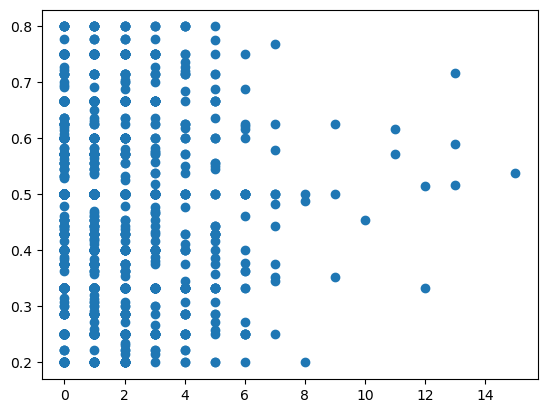

Text(0.5, 1.0, 'Распределение кол-ва волонтеров на пробежке')

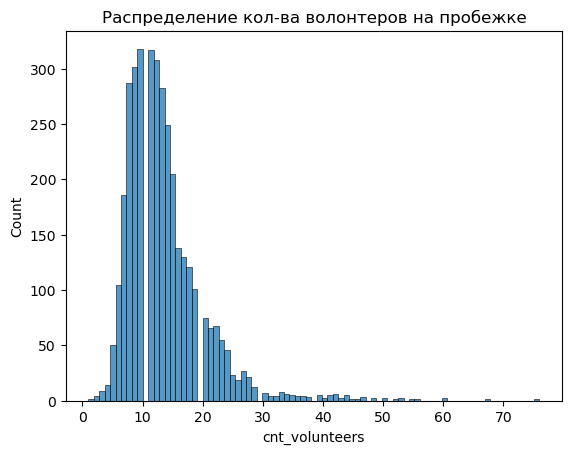

In [197]:
sns.histplot(x=info_about_jogging.cnt_volunteers)
plt.title('Распределение кол-ва волонтеров на пробежке')

Text(0.5, 1.0, 'Распределение доли не придущих новичков на 2 пробежку')

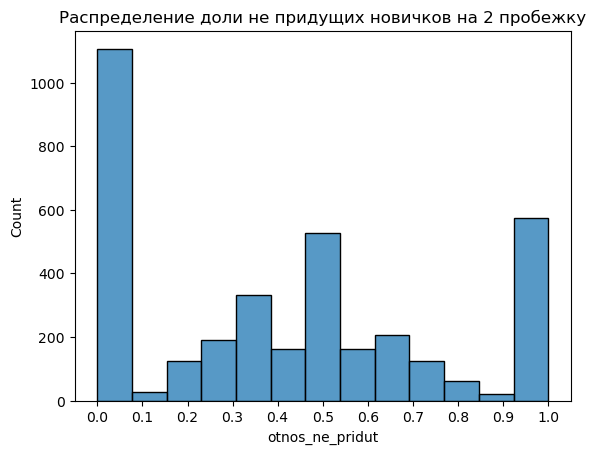

In [198]:
sns.histplot(x=info_about_jogging.otnos_ne_pridut)
plt.xticks([(i/10) for i in range(0, 11)])
plt.title('Распределение доли не придущих новичков на 2 пробежку')

In [199]:
info_about_jogging[info_about_jogging['otnos_ne_pridut']==0].head(10) 

,event_name,event_date,region,pridut,ne_pridut,vsego_newbie,mean_age,mean_gender,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,cnt_volunteers
10,Александрино,2023-06-17,Санкт-Петербург,2,0,2,53.0,1.0,19,19.629920,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0.0,9
15,Александрино,2023-07-22,Санкт-Петербург,3,0,3,42.0,1.0,23,17.393320,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,2,1,0,0,1,1,0,0,0,1,0,0.0,12
17,Александрино,2023-08-05,Санкт-Петербург,2,0,2,38.5,0.5,26,19.321720,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,2,1,0,0,1,1,0,0,0,1,0,0.0,11
22,Александрино,2023-09-16,Санкт-Петербург,1,0,1,46.0,0.0,17,11.184320,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,2,1,0,0,1,1,0,0,0,1,0,0.0,10
24,Александрино,2023-09-30,Санкт-Петербург,1,0,1,31.0,1.0,22,15.732880,0,0,1,1,0,0,0,1,1,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.0,12
25,Александрино,2023-10-07,Санкт-Петербург,2,0,2,42.0,1.0,21,5.384980,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,2,0,0.0,12
28,Александрино,2023-11-11,Санкт-Петербург,2,0,2,39.5,0.5,29,6.154180,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,2,1,0,0,1,1,0,0,0,1,0,0.0,12
29,Бабушкинский на Яузе,2023-01-14,Москва,1,0,1,41.0,1.0,24,-2.219295,0,3,1,1,0,0,0,1,0,1,0,0,4,0,1,0,0,1,0,0,2,1,0,0,0,0,0,0.0,16
31,Бабушкинский на Яузе,2023-01-28,Москва,1,0,1,33.0,1.0,25,-2.741610,0,1,1,0,0,0,0,1,0,1,0,0,2,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0.0,10
33,Бабушкинский на Яузе,2023-02-18,Москва,1,0,1,40.0,1.0,29,-6.468300,0,2,1,1,0,0,0,1,0,1,0,0,4,0,1,0,0,1,1,0,2,1,0,0,0,2,1,0.0,19


In [34]:
num_col = info_about_jogging.select_dtypes(include=['number'])
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'otnos_ne_pridut':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['otnos_ne_pridut'])  
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
num_col_starts = num_col.drop(columns=insignificant_vars)  



Неподходящие целочисленные переменные: ['Ведущий велосипед', 'Завершение мероприятия', 'Координатор парковки', 'Лидер для слабовидящих', 'Обработка результатов', 'Пейсер', 'Подготовка мероприятия', 'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Разное', 'Связи с общественностью', 'Сортировка карточек', 'Составление отчёта', 'Сурдопереводчик', 'Хранение и доставка оборудования']
16


In [255]:
num_col_starts.head(2)

,pridut,ne_pridut,vsego_newbie,mean_age,mean_gender,cnt_runners,discomfort_index,Замыкающий,Инструктаж новых участников,Маршал,Организатор,Организация финиша,Помощь в раздаче карточек позиций,Раздача карточек позиций,Разное,Секундомер,Сканирование штрих-кодов,Фотограф,otnos_ne_pridut,cnt_volunteers,cluster
0,9,7,16,40.500000,0.500000,81,6.28660,1,0,1,1,0,0,1,0,2,1,2,0.437500,11,0
1,5,4,9,41.555556,0.444444,20,6.67771,1,1,0,1,0,0,1,0,1,1,1,0.444444,10,5


In [256]:
y = num_col_starts['otnos_ne_pridut']
x = num_col_starts.drop(columns=['otnos_ne_pridut', 'cluster', 'pridut', 'ne_pridut', 'vsego_newbie', 'cnt_runners'])
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        otnos_ne_pridut   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     9.361
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           5.71e-22
Time:                        21:42:25   Log-Likelihood:                -1296.1
No. Observations:                3624   AIC:                             2624.
Df Residuals:                    3608   BIC:                             2723.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Text(0, 0.5, 'кол-во всего бегунов на пробежке')

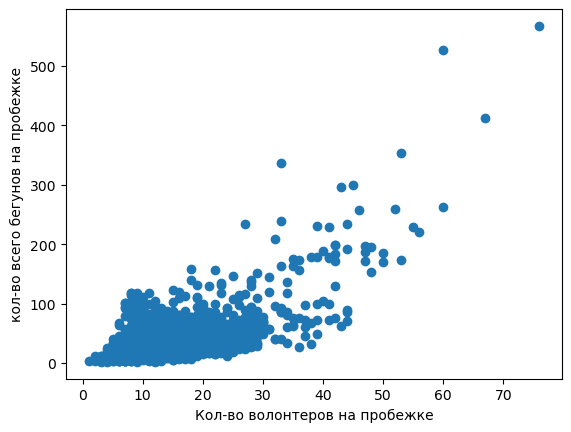

In [200]:
plt.scatter(x=info_about_jogging.cnt_volunteers, y=info_about_jogging.cnt_runners)
plt.xlabel('Кол-во волонтеров на пробежке')
plt.ylabel('кол-во всего бегунов на пробежке')


<Axes: xlabel='discomfort_index', ylabel='Count'>

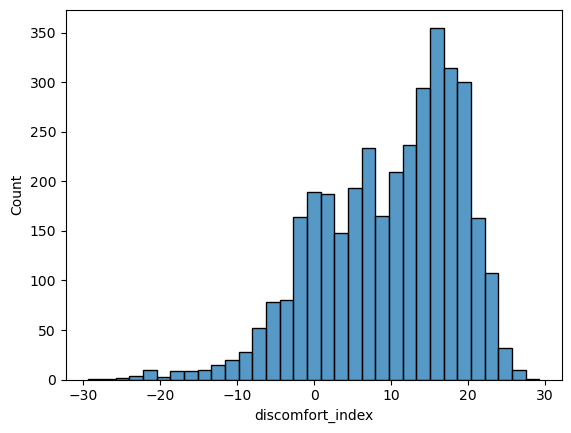

In [201]:
sns.histplot(x=info_about_jogging.discomfort_index)

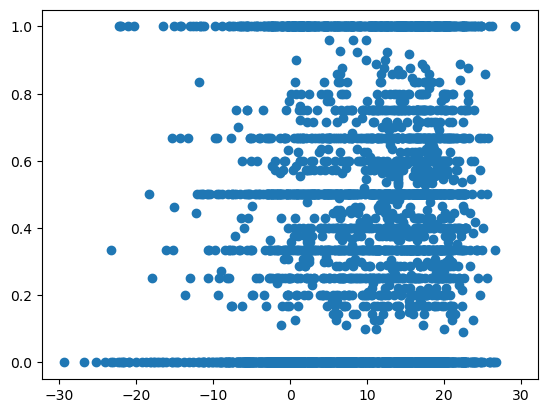

In [202]:
plt.scatter(x=info_about_jogging.discomfort_index, y=info_about_jogging.otnos_ne_pridut)


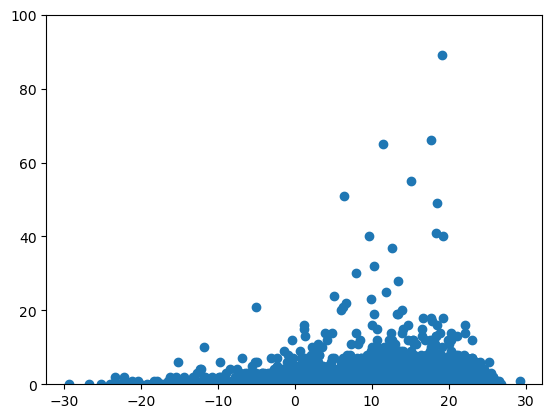

In [203]:
plt.ylim(0, 100)
plt.scatter(x=info_about_jogging.discomfort_index, y=info_about_jogging.ne_pridut)


<Axes: title={'center': 'распред финиш тайм для новичков которые придут во 2 раз'}, xlabel='finish_time', ylabel='Count'>

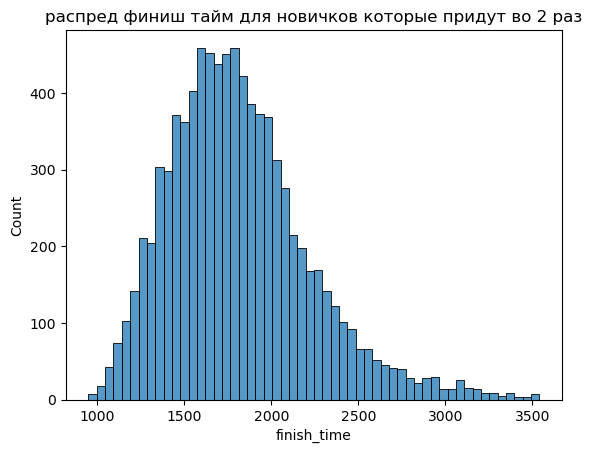

In [204]:
plt.title('распред финиш тайм для новичков которые придут во 2 раз')
sns.histplot(first_runs[first_runs.is_repeated==1].finish_time)

<Axes: title={'center': 'распред финиш тайм для новичков которые НЕ придут больше'}, xlabel='finish_time', ylabel='Count'>

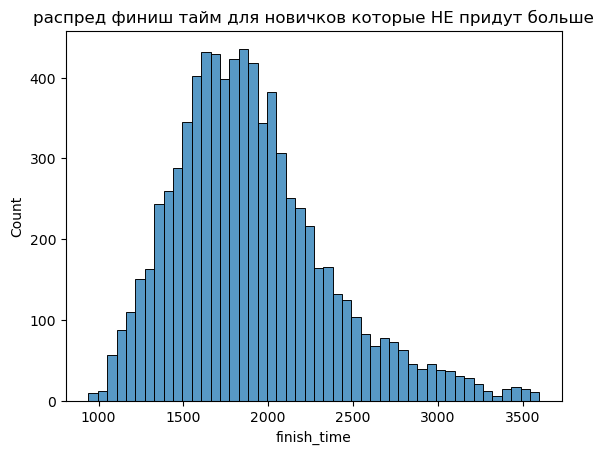

In [205]:
plt.title('распред финиш тайм для новичков которые НЕ придут больше')
sns.histplot(first_runs[first_runs.is_repeated==0].finish_time)

In [206]:
stat, p_value = stats.mannwhitneyu(first_runs[first_runs.is_repeated==0].finish_time, first_runs[first_runs.is_repeated==1].finish_time)  

# Выводим результаты  
print(f'Statistic: {stat}, p-value: {p_value}')  
print(first_runs[first_runs.is_repeated==1].finish_time.mean(), first_runs[first_runs.is_repeated==0].finish_time.mean())
# Интерпретируем результаты  
alpha = 0.05  
if p_value < alpha:  
    print('Отвергаем нулевую гипотезу: средние выборок статистически различаются.')  
else:  
    print('Не удалось отвергнуть нулевую гипотезу: средние выборок не различаются.')  

Statistic: 37436873.0, p-value: 2.7353233125906573e-31
1813.055753945398 1899.2434994235941
Отвергаем нулевую гипотезу: средние выборок статистически различаются.


D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

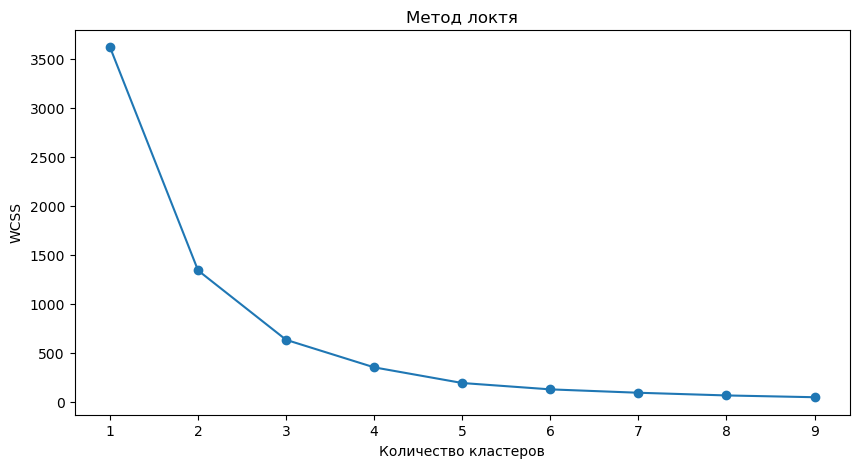

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   cluster  cnt_volunteers  vsego_newbie   ne_pridut
0        0       18.466102     13.021186    6.317797
1        1       12.007780      1.798627    0.696568
2        2       68.000000    356.000000  335.000000
3        3       30.981481     31.851852   15.888889
4        4       35.000000     88.875000   55.625000
5        5       14.632133      5.568042    2.476734


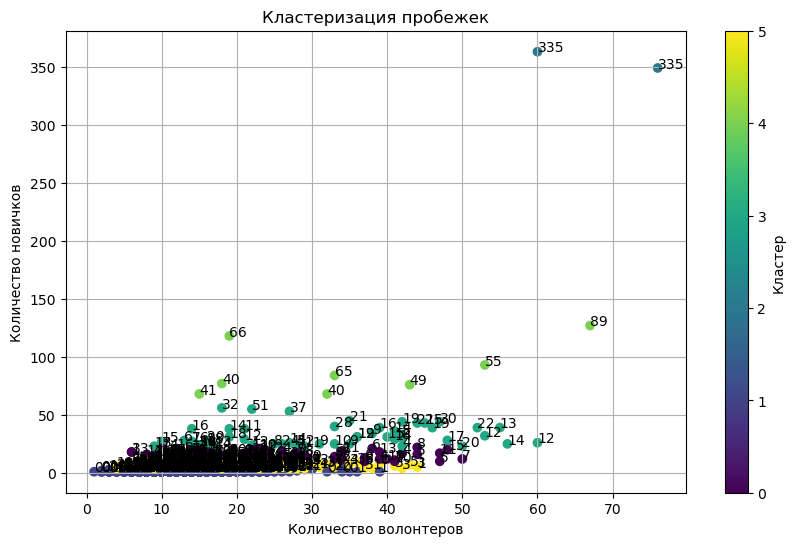

In [207]:
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler


# 2. Подготовьте данные для кластеризации  
X = info_about_jogging[['vsego_newbie']].values  

# Стандартизация данных (это важно для K-Means)  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  

# 3. Выбор количества кластеров  
# Один из способов - это метод локтя, когда мы просматриваем сумму квадратов расстояний:  
wcss = []  
for i in range(1, 10):  
    kmeans = KMeans(n_clusters=i, random_state=0)  
    kmeans.fit(X_scaled)  
    wcss.append(kmeans.inertia_)  

# Визуализируйте метод локтя  
plt.figure(figsize=(10, 5))  
plt.plot(range(1, 10), wcss, marker='o')  
plt.title('Метод локтя')  
plt.xlabel('Количество кластеров')  
plt.ylabel('WCSS')  
plt.show()  

# Выберите количество кластеров (например, 3 на основе метода локтя)  
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0)  
info_about_jogging['cluster'] = kmeans.fit_predict(X_scaled)  

# 4. Анализ  
# Сравните средние значения в группах  
grouped = info_about_jogging.groupby('cluster').agg({  
    'cnt_volunteers': 'mean',  
    'vsego_newbie': 'mean',  
    'ne_pridut': 'mean'  
}).reset_index()  

print(grouped)  

# 5. Визуализация кластеров  
plt.figure(figsize=(10, 6))  
plt.scatter(info_about_jogging['cnt_volunteers'], info_about_jogging['vsego_newbie'],   
            c=info_about_jogging['cluster'], cmap='viridis', marker='o')  
plt.title('Кластеризация пробежек')  
plt.xlabel('Количество волонтеров')  
plt.ylabel('Количество новичков')  
plt.colorbar(label='Кластер')  
plt.grid(True)  

# Показать численность новичков, которые не придут на второй раз  
for idx, row in info_about_jogging.iterrows():  
    plt.annotate(f"{row['ne_pridut']}", (row['cnt_volunteers'], row['vsego_newbie']), fontsize=10)  

plt.show()

In [257]:
clst0 = info_about_jogging[(info_about_jogging.cluster == 1) & (info_about_jogging.event_date >= '2023-05-01') & (info_about_jogging.event_date <= '2023-10-01')]

y = clst0['ne_pridut']
x = clst0[['cnt_volunteers', 'discomfort_index', 'mean_age', 'mean_gender']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
display(clst0.ne_pridut.describe())
print(clst0.cnt_volunteers.describe())

                            OLS Regression Results                            
Dep. Variable:              ne_pridut   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     6.346
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           4.80e-05
Time:                        21:44:05   Log-Likelihood:                -1209.2
No. Observations:                1037   AIC:                             2428.
Df Residuals:                    1032   BIC:                             2453.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9812      0.170  

count    1037.000000
mean        0.788814
std         0.786438
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: ne_pridut, dtype: float64

count    1037.000000
mean       11.840887
std         4.586444
min         2.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        36.000000
Name: cnt_volunteers, dtype: float64
